<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal statement here
To discuss:
- Scaling performance in terms of data volume and resource allocated

- Parallelism via GPUs

- Comparison between parallel and single-machine problems



• additional implementation if an oﬀ-the-shelf implementation falls
short,
• exploring multiple implementations,
• examining the mathematical details of choices.
identifying an appropriate dataset;
• using your understanding of the structure of datasets to make ar-
guments comparing the dataset you chose to one that you might
encounter in a “real” data-science setting;
• plotting or otherwise describing various inputs, outputs, or parame-
ters.
(c) the correctness of the methods used to achieve their stated goals.
(d) the robustness of the results in supporting the conclusions.




# Introduction


**To include in intro: Clearly outline our goal (choose an appropriate scientific/analysis question) , discuss our goal in more detail here, mention how we would scale to a deployable data-science solution. **


We focus on Image classification using Convolutional Neural Networks. Our goal is to investigate how different optimisation strategies and model architectures affect classification accuracy and robustness, and to determine which methods generalise best when scaled to more complex and realistic datasets.

Throughout our project we each carried out a related task to learn more about Neural Networks.
We began exploring CIFAR-10 which we treated as a toy dataset to learn more about optimisation and how the changing of hyperparameters affects the performance of models.
We then generalised to a more realistic dataset,(Food 101) where we created commonly seen CNN models from scratch (ResNet18 and ViT models).

Finally, we tested their robustness by changing our test sets to make them harder for the model to look at, e.g. adding Gaussian blur or changing the brightness of our images.

**Mention: Why we've chosen this **



In [1]:
#Loading necessary libraries
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt #for plotting
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Subset

#libraries used for EDA
import torch
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import entropy

#libraries used for Robustness
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


## About our datasets
### CIFAR-10

The CIFAR-10 dataset can be found online at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

This is a widely used benchmark dataset created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, used for image classification in machine learning methods.

It consists of 60,000 sets of 32x32 images split into 10 classes, such as planes, cars, birds, cats, etc. Of these 50,000 are sued for training and the remaining 10,000 are used for testing.
This makes it a perfect starting point for our project, serving as a toy dataset to better understand neural networks. Due to its low resolution, we are able to explore the impacts of different hyperparameters and hence optimize our neural network.


By experimenting and exploring the effects of different optimization approaches on CIFAR-10, we aim to understand which approaches generalise well before applying them to larger and more complex datasets.
We note some may improve performance specifically on this data set but not generalise so well.

Below we load CIFAR-10:




In [2]:
batch_size = 10 #we can vary the batch size, but this basically shows that ...

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # discuss transforms

In [3]:
#downloading
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#info
print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")
print(f"Classes: {trainset.classes}")


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Training samples: 50000
Testing samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we've loaded the data and we can see the classes and distribution of testing vs training, we can now visualise a small sample (10 images) of the data:

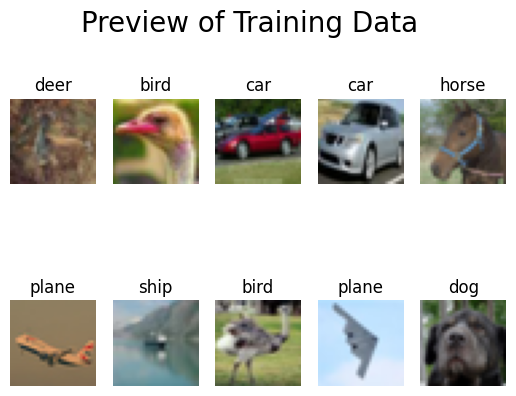

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update

for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Why CIFAR-10 helps you explore these?
How it fits into your project goals?

Since this datasets has been collected in an artificial environment and transformed, weknow that there is an even class distribution and the data has already been split into training and testing.


In [5]:
from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)

for idx, count in label_counts.items():
    print(f"{trainset.classes[idx]}: {count}")

print(images.shape) #printing the size of the images- again we know they're 32x32 so do we need to include??

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000
torch.Size([10, 3, 32, 32])


#EDA on CIFAR-10
**Note: Justify appropriateness of the datasets**

We can obtain information about the mean and standard deviation of the colour channels:

In [6]:
import torch
all_pixels = torch.cat([images.view(-1, 3) for images, _ in trainloader], dim=0)

print(all_pixels.mean(dim=0))#channel mean
print(all_pixels.std(dim=0))#channel std
#this gives us the mean and std for each channel of RGB.

class_means = {}
class_stds = {}

for cls in range(10):
    pixels = []
    for images, labels in trainloader:
        # select only images of this class
        cls_images = images[labels == cls]
        if len(cls_images) == 0:
            continue
        pixels.append(cls_images.view(-1, 3))

    pixels = torch.cat(pixels, dim=0)
    class_means[cls] = pixels.mean(dim=0)
    class_stds[cls] = pixels.std(dim=0)

print(class_means)
print(class_stds)


tensor([-0.0533, -0.0533, -0.0533])
tensor([0.5031, 0.5031, 0.5032])


KeyboardInterrupt: 

As we can see, the mean and std for each of the RGB colour channels are very even. We looked at the RGB distribution for each class to see if one had a larger presence of one colour than the other, which may affect the way the model learns to predict certain colours, but we see these are even.

We can also carry out a statistical pixel analysis for our dataset:

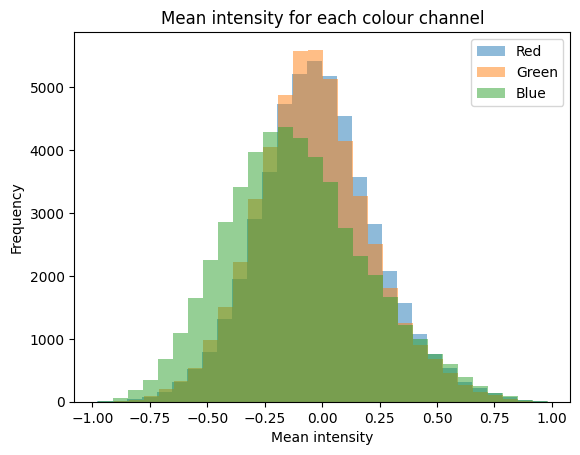

In [7]:
#statitsical pixel analysis for each channel.
r_means, g_means, b_means = [], [], []

#loop through the dataset in batches
for images, _ in trainloader:
  #extracting channels RGB
    r_channel = images[:, 0, :, :]
    g_channel = images[:, 1, :, :]
    b_channel = images[:, 2, :, :]

    r_np = r_channel.numpy()
    g_np = g_channel.numpy()
    b_np = b_channel.numpy()
#then comoute means after we've numpy
    for i in range(r_np.shape[0]):
        r_means.append(np.mean(r_np[i]))
        g_means.append(np.mean(g_np[i]))
        b_means.append(np.mean(b_np[i]))

plt.hist(r_means, bins=30, alpha=0.5, label='Red')
plt.hist(g_means, bins=30, alpha=0.5, label='Green')
plt.hist(b_means, bins=30, alpha=0.5, label='Blue')
plt.legend()
plt.title("Mean intensity for each colour channel")
plt.xlabel("Mean intensity")
plt.ylabel("Frequency")
plt.show()


The above plot shows that each of the colours are centred around 0, suggesting similar colour distributions for each image. They each approximate to a bell curve meaning our dataset is well balanced and diverse in terms of colours.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#loading dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=False)

#we take one big batch of all training data
images, labels = next(iter(trainloader))

#then flatten images and shape
X = images.view(images.shape[0], -1).numpy()
labels = labels.numpy()
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

#now we plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Projection of CIFAR-10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



The PCA (Principal component analysis) shows us that some variation was captured by the principal components, since there is some structure in the points when projected along the two principal component axis. The points belonging to the same class are close to each other, and the points or images that are very different are further away from each other.

In [ ]:
import torch
from scipy.stats import entropy
def image_entropy(img):
    img = img.squeeze()
    entropies = []
    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256).cpu().numpy()
        hist = hist / hist.sum()
        entropies.append(entropy(hist + 1e-8))
    return sum(entropies) / 3
entropies = []
for img, _ in trainloader:
    entropies.append(image_entropy(img))
    #cacl average
avg_entropy = sum(entropies) / len(entropies)
print(f"Average entropy for CIFAR-10: {avg_entropy:.4f}")



The entropy is calculated as ... this can be interpreted as ...


### Food 101

The CIFAR-10 is an idealised dataset where images are trnsformed to make them better suited to image classification. However, this is not reflective of real world scenarios sp we decided to focus on a more complax dataset.

The Food 101 dataset is a large scale dataset composed of realistic photos taken of different dishes. The data set was compiled by (@bossard14) who used images from 'foodspotting.com', a site that allows users to take images of what they are eating, annotate place and type of food, and upload the information online, resulting in this open source dataset.
The creators (@bossard14) created this with the aim of using image clasification with different dishes.

Food typically does not exhibit any distinctive spatial layout, unlike images in the CIFAR-10 dataset where an image with a plane often follows expected visual compositions of the sky in the background.
The images themselves are taken from different angles, different lightings, viewpoints and background context.
For this reason we felt this dataset reflected the complexities of real life scenarios.

This dataset consists of 101 food categories, with 101, 000 images. For each class, 250 manually cleaned test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

This dataset demonstrates a more realistic progression beyond CIFAR-10, allowing us to investigate deeper architectural choices, such as ResNet-18 and ViTs, before comparing model performance under imperfect, real-world conditions.

The data is split in the following way:
- Train: 75,750
- Test: 25,250

Below we import the dataset to get an overview :



In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#loading Food-101 dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [03:57<00:00, 21.0MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Note: The original resolution is 256x256 but due to our limited GPU resources, we reduced to 64x64 to train our models effectively.

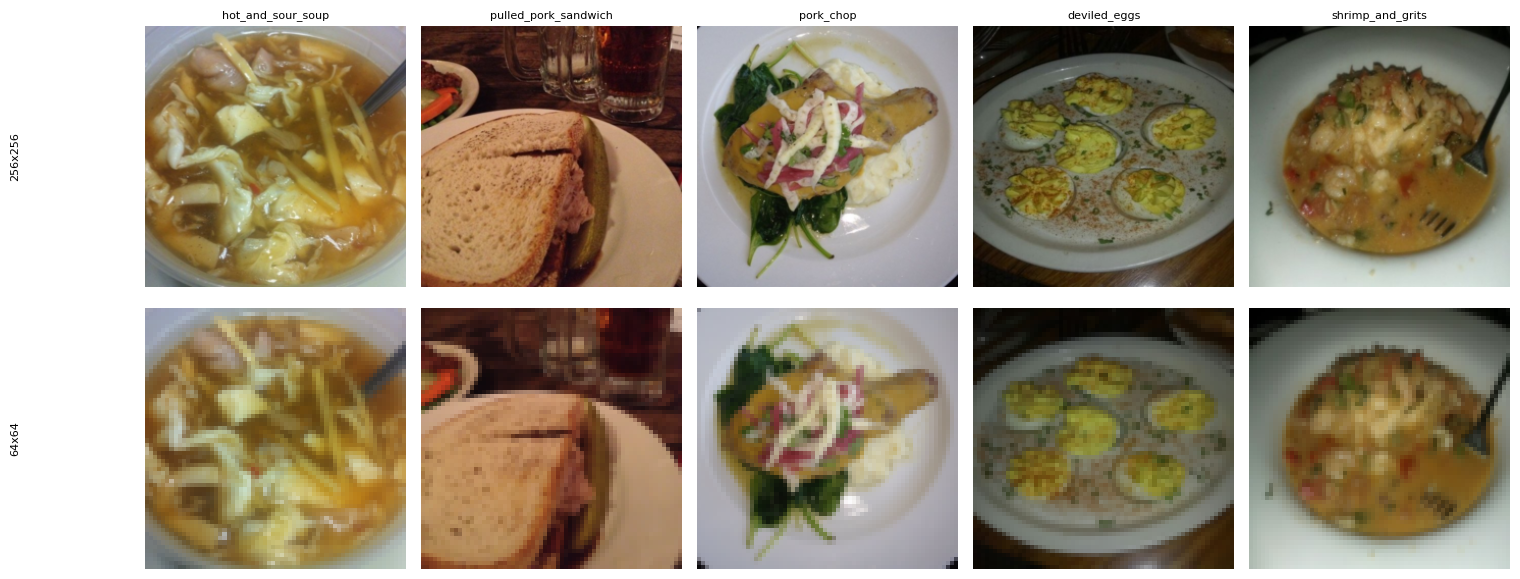

In [9]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

#we transform to 64x64 from the original 256
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  # number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]#to get the class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img) # resizing
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')

            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


In [50]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#making 64x64
transform_food101_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
train_dataset_food101 = datasets.Food101(
    root=food_root,
    split="train",
    transform=transform_food101_64,
    download=False
)

test_dataset_food101 = datasets.Food101(
    root=food_root,
    split="test",
    transform=transform_food101_64,
    download=False
)
#training
train_loader_food101 = DataLoader(
    train_dataset_food101,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader_food101 = DataLoader(
    test_dataset_food101,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"Food-101 train samples: {len(train_dataset_food101)}")
print(f"Food-101 test  samples: {len(test_dataset_food101)}")
print(f"Number of classes: {len(train_dataset_food101.classes)}")



Food-101 train samples: 75750
Food-101 test  samples: 25250
Number of classes: 101


We can see that reducing the resolution in this way makes the images much harder to identify, but due to limitations in time constraints and GPUs for training, we had to reduce to 64x64 to be able to train our models.

# EDA Food 101
Now for some EDA on food 101:

In [12]:
#mean pixels per channel
means, stds = [], []
for img, _ in train_subset:
    img_t = resize_64(img).unsqueeze(0)
    means.append(img_t.mean(dim=[2,3]).flatten())
    stds.append(img_t.std(dim=[2,3]).flatten())
means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)
print("Channel Means:", means)
print("Channel Stds:", stds)


Channel Means: tensor([0.5032, 0.4396, 0.3294])
Channel Stds: tensor([0.1645, 0.1722, 0.1848])


Unlike the CIFAR-10 dataset, we get bigger mean differences between RGB colour channels, suggesting that there is a greater dominance of certain colours preseent in some images.

In [ ]:
from scipy.stats import entropy

def image_entropy(img):
    hist = torch.histc(img, bins=256).cpu().numpy()
    return entropy(hist + 1e-8)

entropies = []
for img, _ in train_subset:
    entropies.append(image_entropy(resize_64(img)))
print("Avg entropy:", sum(entropies)/len(entropies))


Average entropy is a measure of how much variation or randomness there is in an image. A hugh entropy is considered to be ...

Due to the large number of classes we only show the PCA for one batch.

### Literature review

After reviewing (cite ResNet), we concluded that...

## Report

Discuss: appropriate strategy to learn about the computational per-
formance of the models- optimizing and comparing robustness?


Throughout our project we will explore the following:
- Optimization using CIFAR-10, looking at the following:
    - Number of convolutional layers and their impact on model performance
    - Learning rates
    - Optimizers
    - Kernels
    - Max_pool
    - Activation functions
    - Padding
    - And other hyperparameters

-  Creating ResNet18 from Scratch Using PyTorch and comparing to the plain model (cite)
Discuss: Why ResNet?? Why 18 layers ?
Using optimization we found from CIFAR-10


- Creating Transformer model (VIT)
Discuss: Why VIT?


- Using adversarial attack to test model robustness
Using a seperate test set and apply trnsforms such as noise, rotation etc to reflect a real-world scenario.
So here we are applying our models by testing on this set.


Question: Do we reduce the dataset?


# Limitations
- Colab GPU limitations
- Time constraint
- Memory
- Knowledge of Neural Networks


## Optimization using CIFAR-10




Extension: visualising the effct of convolutional layers ?
image explanation of the kernel: https://arxiv.org/pdf/1311.2901

looking at the following:
  - Number of convolutional layers and their impact on model performance
  - Learning rates
  - Optimizers
  - Kernels
  - Max_pool
  - Activation functions
  - Padding
  - And other hyperparameters


Fine tuning? Discuss

## ResNet- 18
ResNet 18 is a pretrained model...
It  uses 18 convolutional layers.
After reading (cite), ...


Transfer learning ? - discuss

Kat use this video - https://www.youtube.com/watch?v=DkNIBBBvcPs

Discuss this paper to justify choice of layers and resnet : ResNet architecture: https://arxiv.org/pdf/1512.03385

## VIT Transformer
A 'state of the art' ....

Vision transformers and ViT architecture: https://arxiv.org/pdf/2010.11929

## Training from scratch

## Transfer learning

## Testing robustness
We compare robustness of our models by transforming our images and seeing how this affects our results.
Comparing robustness:

After reading https://ieeexplore.ieee.org/document/11098661, we discovered a number of ways we could adjust our iages to challenge the model.
We've modified the test set in the following way:

- Adding noise
- Random rotations
- Brightness
- Defocus
- Pixelate
- Fog attack
- Frost attack



In [13]:
#libraries just for robustness
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

We add blurs and noise etc at different severities, this way we get a very clear visualisation of how this affects all of the models.

In [14]:
SEVERITY_LEVELS = [1, 2, 3, 4, 5]

import cv2
import numpy as np
import torch
import torch.nn.functional as F

#adding noise
def add_noise(images, severity):
    noise_level = 0.05 * severity
    noise = torch.randn_like(images) * noise_level
    return torch.clamp(images + noise, -1, 1).float()

#brightness
def change_brightness(images, severity):
    factor = 1 - 0.15 * severity
    return torch.clamp(images * factor, -1, 1).float()

#gaussian blur
def defocus_blur(images, severity):
    kernel_size = 2 * severity + 1  # 3, 5, 7, 9, 11
    blurred = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()   # (H,W,C)
        npimg_blur = cv2.GaussianBlur(npimg, (kernel_size, kernel_size), 0)
        blurred.append(torch.tensor(npimg_blur).permute(2,0,1))
    return torch.stack(blurred).clamp(-1,1).float()

#pixelate
def pixelate(images, severity):
    scale_down = 2 + severity * 2    # 4, 6, 8, 10, 12
    pixelated = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        h, w = npimg.shape[:2]               # ← works for 32×32 or 64×64
        small = cv2.resize(npimg, (h//scale_down, w//scale_down), interpolation=cv2.INTER_LINEAR)
        big = cv2.resize(small, (h, w), interpolation=cv2.INTER_NEAREST)  # ← resize back to original size
        pixelated.append(torch.tensor(big).permute(2,0,1))
    return torch.stack(pixelated).clamp(-1,1).float()

#fog
def add_fog(images, severity):
    fog_strength = 0.1 * severity
    foggy = []
    for img in images:
        npimg = img.cpu().numpy()
        h, w = npimg.shape[1], npimg.shape[2]
        fog = np.random.normal(0.5, 0.2, (3, h, w))
        foggy.append(torch.tensor(npimg + fog_strength * fog))
    return torch.stack(foggy).clamp(-1,1).float()

#frost
def frost(images, severity):
    frost_strength = 0.15 * severity
    frosted = []
    for img in images:
        npimg = img.cpu().numpy()
        frost_noise = np.random.normal(0.7, 0.3, npimg.shape)
        frosted_img = npimg * (1 - frost_strength) + frost_strength * frost_noise
        frosted.append(torch.tensor(frosted_img))
    return torch.stack(frosted).clamp(-1,1).float()


Now we apply these attacks to our CIFAR-10 dataset, using Severity=3 from the 1-5 scale for visualisation.

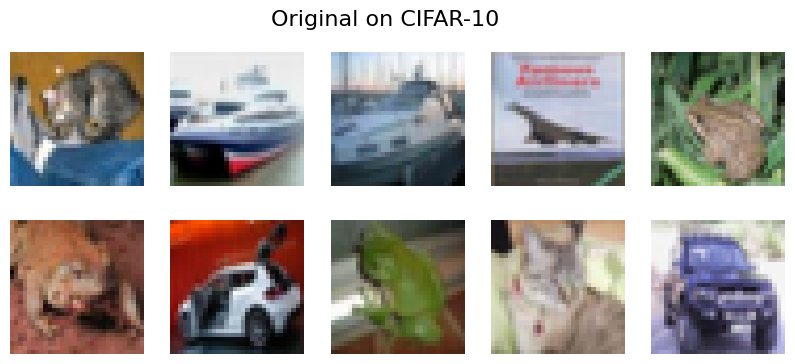

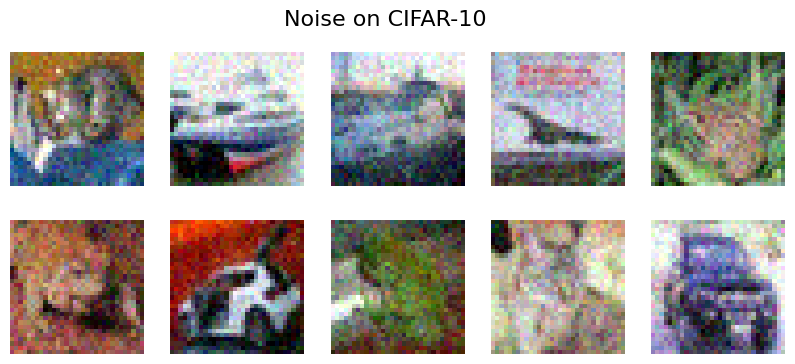

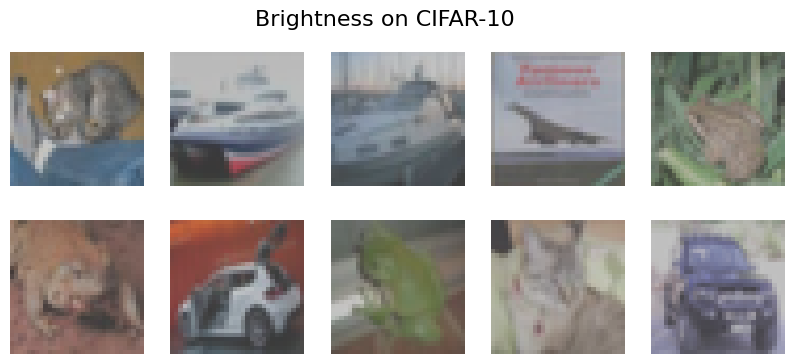

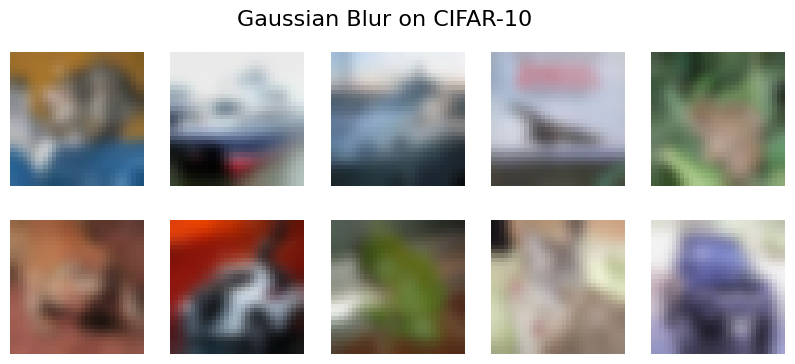

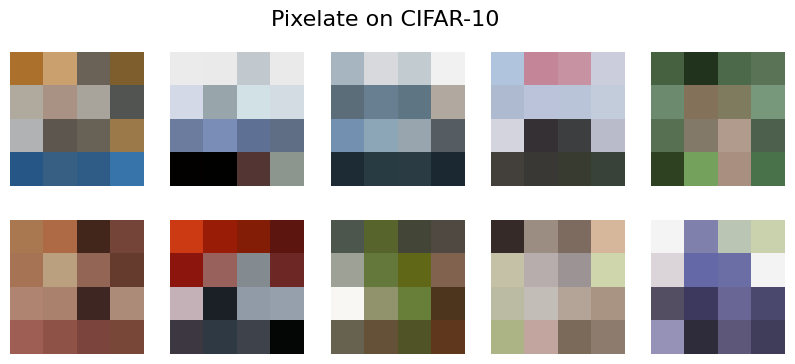

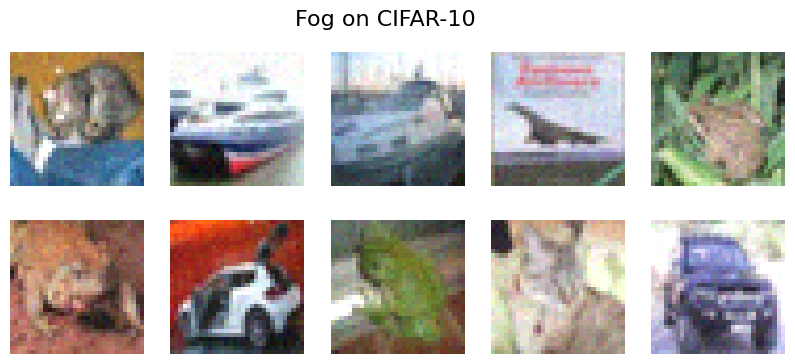

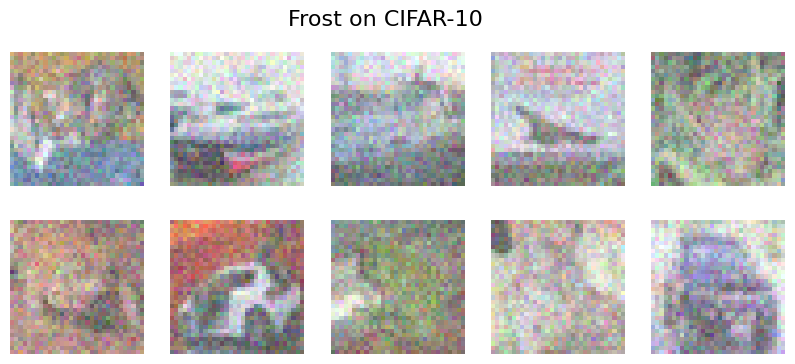

In [15]:
import matplotlib.pyplot as plt

SEVERITY = 3 #we have severity ranging 1-5, so choose the mid severity on these

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[:10]  #show 10 images

attacks = {
    "Original": images,
    "Noise": add_noise(images, SEVERITY),
    "Brightness": change_brightness(images, SEVERITY),
    "Gaussian Blur": defocus_blur(images, SEVERITY),
    "Pixelate": pixelate(images, SEVERITY),
    "Fog": add_fog(images, SEVERITY),
    "Frost": frost(images, SEVERITY)
}

for name, attacked_imgs in attacks.items():
    plt.figure(figsize=(10, 4))
    for i in range(10):
        img = attacked_imgs[i] / 2 + 0.5  # unnormalise for display
        npimg = img.cpu().numpy()
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    plt.suptitle(f'{name} on CIFAR-10', size=16)
    plt.show()


In [16]:
from torch.utils.data import TensorDataset, DataLoader

def evaluate_attack(model, attack_fn, testloader):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for severity in SEVERITY_LEVELS:
            correct = total = 0
            for images, labels in testloader:
                images = attack_fn(images, severity)
                outputs = model(images.to(device))
                _, preds = torch.max(outputs, 1)
                correct += (preds.cpu() == labels).sum().item()
                total += labels.size(0)
            accuracies.append(100 * correct / total)
    return accuracies

To load the models in to colab, we downloaded them to google drive and used this approach- there must be a better way to do this?


In [18]:
from google.colab import drive
drive.mount('/content/drive')

#this allows us to load within colab

Mounted at /content/drive


In [24]:
import torch
import torch.nn as nn

file_path_resnet = "/content/drive/MyDrive/Resnet18.py" # already uploaded

with open(file_path_resnet, "r") as f:
    resnet_code = f.read()

exec(resnet_code)  # defines ResNet18_CIFAR10 in memory
print("ResNet18 definition loaded successfully!")

ResNet18_acc_PATH  = "/content/drive/MyDrive/resnet18_cifar10_best_acc.pth"
ResNet18_loss_PATH = "/content/drive/MyDrive/resnet18_cifar10_best_loss.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_res_acc  = ResNet18(num_classes=10).to(device)
model_res_loss = ResNet18(num_classes=10).to(device)

# Load weights
state_res_acc  = torch.load(ResNet18_acc_PATH,  map_location=device)
state_res_loss = torch.load(ResNet18_loss_PATH, map_location=device)

model_res_acc.load_state_dict(state_res_acc)
model_res_loss.load_state_dict(state_res_loss)

model_res_acc.eval()
model_res_loss.eval()

print("ResNet18 best-acc and best-loss models loaded successfully! 🚀")



ResNet18 definition loaded successfully!
ResNet18 best-acc and best-loss models loaded successfully! 🚀


In [25]:
import torch
import torch.nn as nn

file_path_vit = "/content/drive/MyDrive/SL_Vit.py"   # already uploaded here

with open(file_path_vit, "r") as f:
    vit_code = f.read()

exec(vit_code)   # defines ViT in memory
print("SLViT architecture loaded successfully!")

Vit_acc_PATH  = "/content/drive/MyDrive/slvit_cifar10_best_acc.pth"
Vit_loss_PATH = "/content/drive/MyDrive/slvit_cifar10_best_loss.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vit_acc = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model_vit_loss = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

# Load weights
state_vit_acc  = torch.load(Vit_acc_PATH,  map_location=device)
state_vit_loss = torch.load(Vit_loss_PATH, map_location=device)

model_vit_acc.load_state_dict(state_vit_acc)
model_vit_loss.load_state_dict(state_vit_loss)

model_vit_acc.eval()
model_vit_loss.eval()

print("SLViT best-ACC and best-LOSS models loaded")


SLViT architecture loaded successfully!
SLViT best-ACC and best-LOSS models loaded successfully! 🚀


In [26]:
attack_results_Res_acc = {
    "Noise":       evaluate_attack(model_res_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_acc, frost, testloader),
}

attack_results_Res_loss = {
    "Noise":       evaluate_attack(model_res_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_loss, frost, testloader),
}


In [27]:
attack_results_Vit_acc = {
    "Noise":       evaluate_attack(model_vit_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_acc, frost, testloader),
}


attack_results_Vit_loss = {
    "Noise":       evaluate_attack(model_vit_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_loss, frost, testloader),
}



<Figure size 640x480 with 0 Axes>

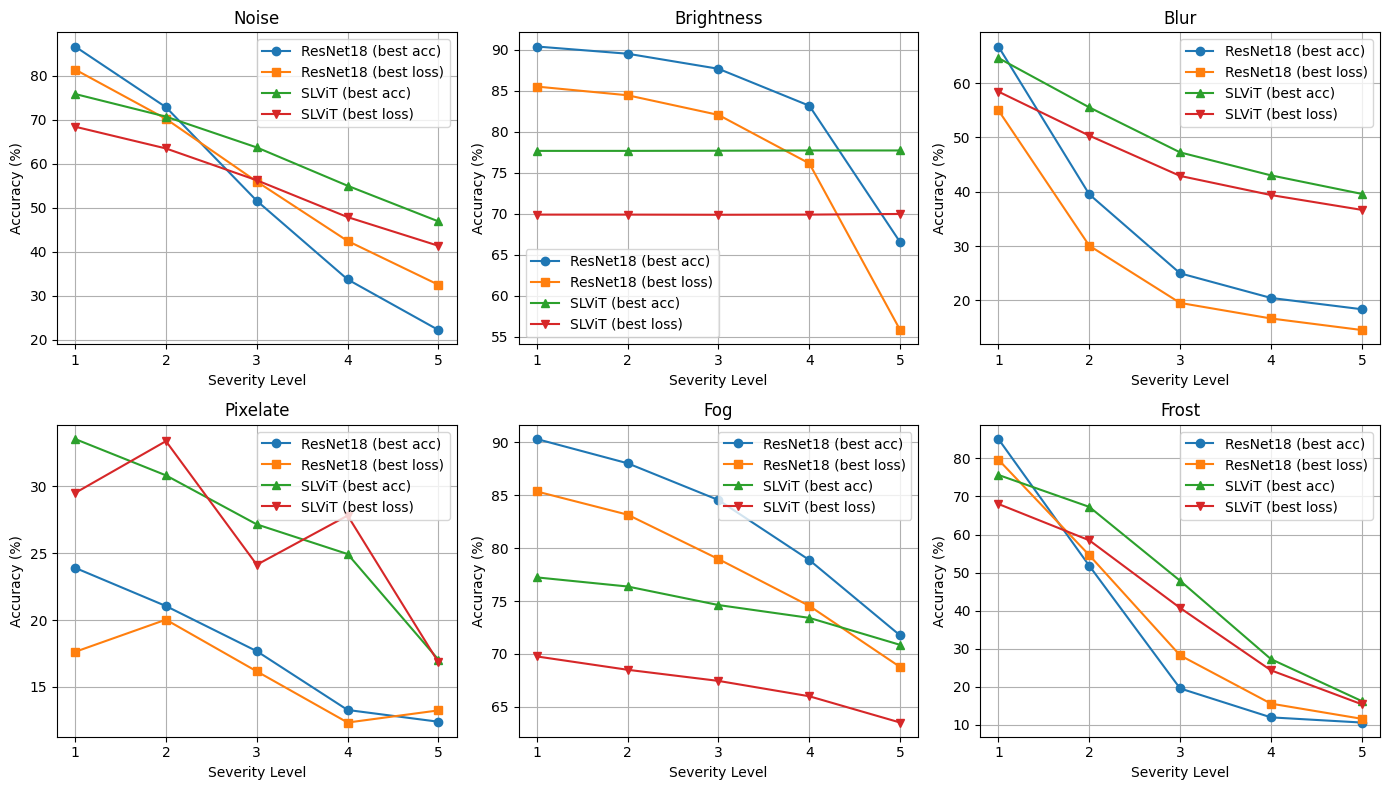

In [28]:
import matplotlib.pyplot as plt

# --- Titles for clarity ---
plt.suptitle("CIFAR-10 Robustness", fontsize=16, y=1.02)

attacks = list(attack_results_Res_acc.keys())
num_attacks = len(attacks)

rows, cols = 2, 3  # 6 attack types → 2 rows, 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    # Get curves for each model
    acc_curve_res   = attack_results_Res_acc[attack_name]
    loss_curve_res  = attack_results_Res_loss[attack_name]
    acc_curve_vit   = attack_results_Vit_acc[attack_name]
    loss_curve_vit  = attack_results_Vit_loss[attack_name]

    # Plot
    ax.plot(SEVERITY_LEVELS, acc_curve_res,   marker='o', label='ResNet18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_res,  marker='s', label='ResNet18 (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,   marker='^', label='SLViT (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_vit,  marker='v', label='SLViT (best loss)')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend()

# Hide unused axes if any remain
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



So now we've effectively created our modified test sets hat can be used to test the model's robustness on the CIFAR-10 dataset. The modifications and attack choices were chosen due to teh fact the mirror modifications that we might encounter in a real world scenario.

# Adversarial attack on Food 101
Despite the fact these images are collected from a real world scenario, hence already including varied brightnesses and blur, we enhance these to test the robustness of our models.

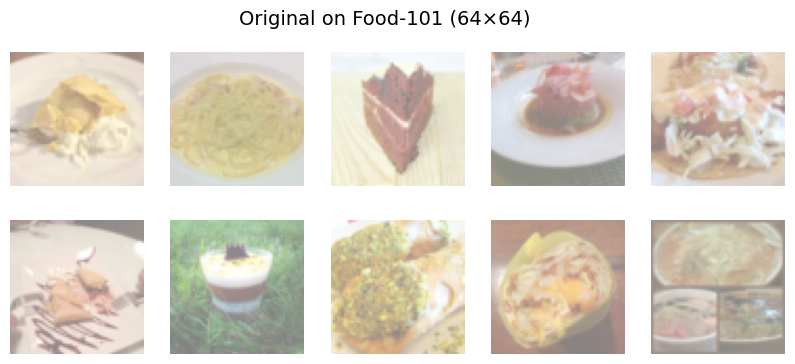

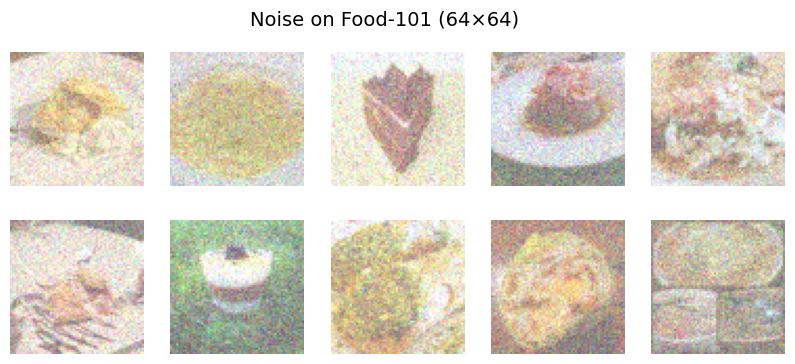

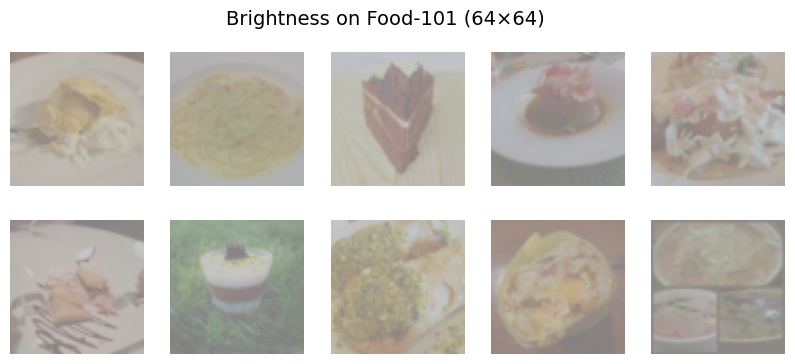

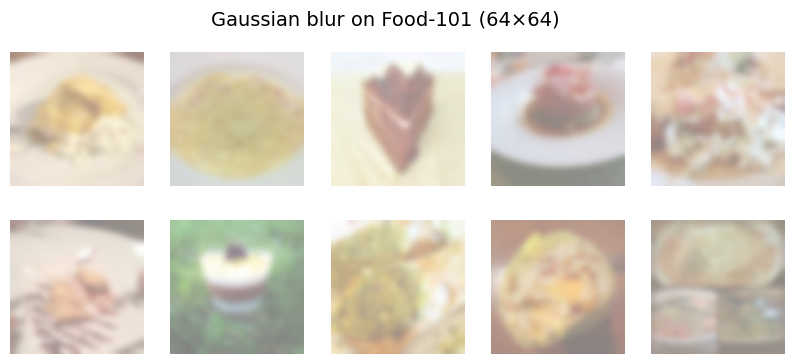

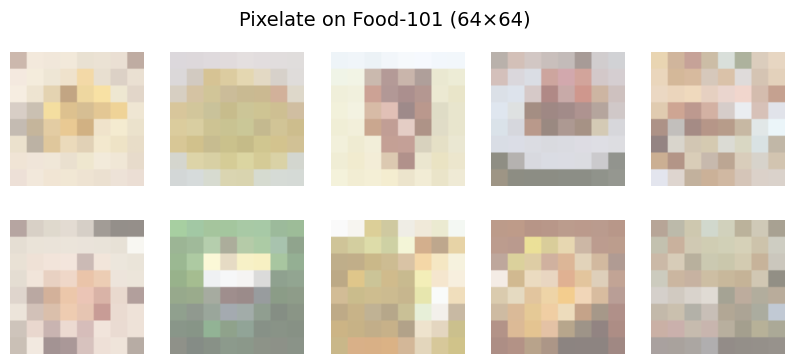

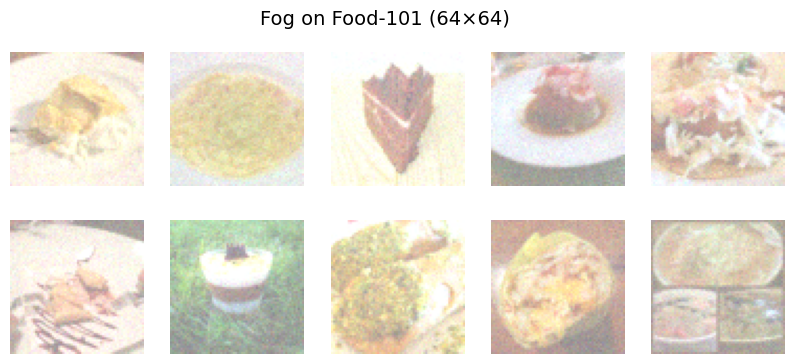

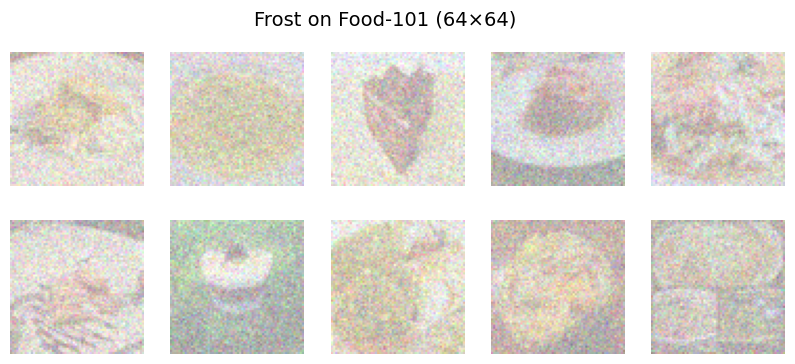

In [52]:
tensor_images = []
labels_list  = []

for img, label in train_subset:
    tensor_images.append(img)    # img is already a 64×64 tensor
    labels_list.append(label)

images_64 = torch.stack(tensor_images)
labels_64 = torch.tensor(labels_list)

modifications = {
    "Original":    images_64,
    "Noise":       add_noise(images_64, severity=3),
    "Brightness":  change_brightness(images_64, severity=3),
    "Gaussian blur": defocus_blur(images_64, severity=3),
    "Pixelate":    pixelate(images_64, severity=3),    # automatically keeps 64×64!
    "Fog":         add_fog(images_64, severity=3),
    "Frost":       frost(images_64, severity=3)
}

# 🎨 Visualisation
for name, attacked_imgs in modifications.items():
    plt.figure(figsize=(10, 4))
    for i in range(len(attacked_imgs)):
        img = attacked_imgs[i] / 2 + 0.5
        npimg = img.numpy().transpose(1, 2, 0)
        plt.subplot(2, 5, i + 1)
        plt.imshow(npimg)
        plt.axis('off')
    plt.suptitle(f'{name} on Food-101 (64×64)', size=14)
    plt.show()



Now we apply our neural networks to our adversarial attack datasets, the results can be seen in the visualisation below. But first we must load the models.





In [53]:
import torch
import torch.nn as nn

# ---- Load the architecture from your uploaded file ----
file_path_resnet = "/content/drive/MyDrive/Resnet18.py"  # already uploaded

with open(file_path_resnet, "r") as f:
    resnet_code = f.read()

exec(resnet_code)   # defines ResNet18_CIFAR10 in memory
print("ResNet18 architecture loaded successfully!")

ResNet18_food_PATH = "/content/drive/MyDrive/resnet18_food101_best.pth"  # <--- ATTACHED FILE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model_food_res = ResNet18(num_classes=101).to(device)

# Load state dict
state_food_res= torch.load(ResNet18_food_PATH, map_location=device)
model_food_res.load_state_dict(state_food_res)
model_food_res.eval()

print("ResNet18 Food-101 model loaded successfully! 🍔🚀")



ResNet18 architecture loaded successfully!
ResNet18 Food-101 model loaded successfully! 🍔🚀


In [54]:
import torch
import torch.nn as nn

# ---- Load SLViT architecture from your uploaded file ----
file_path_vit = "/content/drive/MyDrive/SL_Vit.py"   # already uploaded

with open(file_path_vit, "r") as f:
    vit_code = f.read()

exec(vit_code)   # defines ViT in memory
print("SLViT architecture loaded successfully!")

# ---- Load FOOD-101 weights ----
Vit_food_PATH  = "/content/drive/MyDrive/slvit_food101_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_food_vit():
    return ViT(
        image_size = 64,     # Very likely correct
        patch_size = 8,      # FIX → inferred from checkpoint
        num_classes = 101,
        dim = 256,
        depth = 6,           # Likely same
        heads = 8,
        mlp_dim = 512,
        dropout = 0.1,
        emb_dropout = 0.1
    )
model_vit_food = make_food_vit().to(device)
state_vit_food = torch.load(Vit_food_PATH, map_location=device)

model_vit_food.load_state_dict(state_vit_food)
model_vit_food.eval()

print("SLViT Food-101 BEST-ACC & BEST-LOSS loaded")


SLViT architecture loaded successfully!
SLViT Food-101 BEST-ACC & BEST-LOSS loaded successfully! 🧠🍜


In [ ]:
attack_results_Food101_ResNet_best = {
    "Noise":       evaluate_attack(model_food_res, add_noise, test_loader_food101),
    "Brightness":  evaluate_attack(model_food_res, change_brightness, test_loader_food101),
    "Blur":        evaluate_attack(model_food_res, defocus_blur, test_loader_food101),
    "Pixelate":    evaluate_attack(model_food_res, pixelate, test_loader_food101),
    "Fog":         evaluate_attack(model_food_res, add_fog, test_loader_food101),
    "Frost":       evaluate_attack(model_food_res, frost, test_loader_food101),
}


In [ ]:
attack_results_Food101_ViT_best = {
    "Noise":       evaluate_attack(model_vit_food, add_noise, test_loader_food101),
    "Brightness":  evaluate_attack(model_vit_food, change_brightness, test_loader_food101),
    "Blur":        evaluate_attack(model_vit_food, defocus_blur, test_loader_food101),
    "Pixelate":    evaluate_attack(model_vit_food, pixelate, test_loader_food101),
    "Fog":         evaluate_attack(model_vit_food, add_fog, test_loader_food101),
    "Frost":       evaluate_attack(model_vit_food, frost, test_loader_food101),
}



In [ ]:
import matplotlib.pyplot as plt

plt.suptitle("Food-101 Robustness", fontsize=16, y=1.02)

attacks = list(attack_results_Food101_ResNet_best.keys())
num_attacks = len(attacks)

rows, cols = 2, 3  # 6 attacks → 2×3 grid
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    # Get severity curves for both models
    acc_curve_resnet = attack_results_Food101_ResNet_best[attack_name]
    acc_curve_vit    = attack_results_Food101_ViT_best[attack_name]

    # Plot curves
    ax.plot(SEVERITY_LEVELS, acc_curve_resnet, marker='o', label='ResNet18')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,    marker='s', label='SLViT')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend(fontsize=8)

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



# t-SNE on CIFAR-10 Gaussian noise
t-SNE is a really clear way to ...

In [ ]:
# Load your model definitions
from Resnet18 import ResNet18_CIFAR10   # adjust if class name differs
from SL_Vit import ViT                # adjust if class name differs

# Create feature models (no FC at the end)
feature_model_res = nn.Sequential(*list(model_res_acc.children())[:-1]).to(device)
feature_model_res.eval()

# For ViT → use CLS token BEFORE classifier
class ViT_FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x, return_embedding=True)  # only if forward() supports this

feature_model_vit = ViT_FeatureExtractor(model_vit_acc).to(device)
feature_model_vit.eval()


In [ ]:
def extract_features(model, dataloader, severity=None, max_samples=1200):
    features, labels = [], []
    count = 0

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            # Apply Gaussian blur if needed
            if severity is not None:
                imgs = defocus_blur(imgs, severity).to(device)

            feats = model(imgs)

            features.append(feats.cpu())
            labels.append(lbls.cpu())

            count += imgs.size(0)
            if count >= max_samples:
                break

    return torch.cat(features), torch.cat(labels)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features, labels = extract_features(feature_model_res, testloader, severity=None)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features.numpy())

classes = trainset.classes

plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1],
                      c=labels, cmap='tab10', s=15, alpha=0.7)

handles, _ = scatter.legend_elements()
plt.legend(handles, classes, title="Classes", loc="best")

plt.title("t-SNE of CIFAR10 (ResNet18 Features)")
plt.xlabel("TSNE - Dimension 1")
plt.ylabel("TSNE - Dimension 2")
plt.grid(alpha=0.4, linestyle='--')
plt.show()


# Results
 -Time
 -Accuracy
 -Loss


# References
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}


@ARTICLE{robustness,
  author={Kumar, Vishesh and Shukla, Shivam and Agarwal, Akshay},
  journal={IEEE Transactions on Big Data},
  title={Robustness Benchmarking of Convolutional and Transformer Architectures for Image Classification},
  year={2025},
  volume={11},
  number={6},
  pages={3330-3341},
  keywords={Robustness;Transformers;Image resolution;Image quality;Image classification;Distortion;Computer vision;Image coding;Deep learning;Benchmark testing;Corruption;convolution;transformer;robustness;explainability},
  doi={10.1109/TBDATA.2025.3593385}}
